In [1]:
import nlpaug.augmenter.word as naw

import gensim
from gensim.models import Word2Vec

In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import sentiwordnet as swn

In [3]:
def sentiment(sentence):
    import nltk
    from nltk.corpus import wordnet as wn
    from nltk.corpus import sentiwordnet as swn
    from nltk.tag import pos_tag
    
    token = nltk.word_tokenize(sentence)
    after_tagging = nltk.pos_tag(token)
    
    def penn_to_wn(tag):
        """
        Convert between the PennTreebank tags to simple Wordnet tags
        """
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        elif tag.startswith('V'):
            return wn.VERB
        return None
    
    pos_score = 0.0
    neg_score = 0.0
    obj_score = 0.0
    tokens_count = 0
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    for word, tag in after_tagging:
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue
        
        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            continue
        
        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets:
            continue
        
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        
        pos_score += swn_synset.pos_score()
        neg_score += swn_synset.neg_score()
        obj_score += swn_synset.obj_score()
        tokens_count += 1
    
    try:
        pos_score /= tokens_count
        neg_score /= tokens_count
        obj_score /= tokens_count
    except:
        pass
    
    return [pos_score, neg_score, obj_score]

In [4]:
def aug_glove_getter(encoding_dim: int):
    path_to_glove_file = "GloVe_data/glove.twitter.27B." + str(encoding_dim) + "d.txt"
    return naw.WordEmbsAug(model_type='glove', model_path=path_to_glove_file, aug_min=1, aug_max=4)
aug_glove_25  = aug_glove_getter(25)
aug_glove_50  = aug_glove_getter(50)
aug_glove_100 = aug_glove_getter(100)
aug_glove_200 = aug_glove_getter(200)
aug_bert = naw.ContextualWordEmbsAug(model_type="bert", aug_min=1, aug_max=4)
aug_wn = naw.SynonymAug(aug_src="wordnet", aug_min=1, aug_max=4)

In [47]:
def get_augments(tweet: str, aug_ratio: int, aug_factor: int=4):
    n_augments = aug_ratio * aug_factor
    
    aug_glove_25_tweets  = aug_glove_25.augment(tweet, n = n_augments)
    aug_glove_50_tweets  = aug_glove_50.augment(tweet, n = n_augments)
    aug_glove_100_tweets = aug_glove_100.augment(tweet, n = n_augments)
    aug_glove_200_tweets = aug_glove_200.augment(tweet, n = n_augments)
    aug_bert_tweets = aug_bert.augment(tweet, n = 2*n_augments)
    aug_wn_tweets = aug_wn.augment(tweet, n = 2*n_augments)
    
    df = pd.DataFrame({"tweet" : np.concatenate([
        [tweet],
        aug_glove_25_tweets,
        aug_glove_50_tweets,
        aug_glove_100_tweets,
        aug_glove_200_tweets,
        aug_bert_tweets,
        aug_wn_tweets
    ])})
    
    df["sentiment"] = df["tweet"].map(lambda tweet: sentiment(tweet))
    
    df["pos"] = df["sentiment"].map(lambda score: score[0])
    df["neg"] = df["sentiment"].map(lambda score: score[1])
    df["obj"] = df["sentiment"].map(lambda score: score[2])

    df["delta_pos"] = df["pos"] - df["pos"][0]
    df["delta_neg"] = df["neg"] - df["neg"][0]
    df["delta_obj"] = df["obj"] - df["obj"][0]

    df["delta_sq"] = df["delta_pos"]**2 + df["delta_neg"]**2 + df["delta_obj"]**2
    df = df.drop(["sentiment", "delta_pos", "delta_neg", "delta_obj"], axis = 1)

    df = df.sort_values(by="delta_sq", ascending=True, ignore_index=True)
    
    #print("Closest matches:", end="\n    ")
    #for close_tweet in df["tweet"][1:aug_ratio+1]:
    #    print(close_tweet, end="\n    ")
    
    return df.iloc[1:aug_ratio+1]

In [48]:
tweet = "Round 5 of Happy Hour and all is well."
get_augments(tweet, 3)

,tweet,pos,neg,obj,delta_sq
1,Troll 5 of Happy Minute and all represent well.,0.3125,0.0,0.6875,0.0
2,Round five of Happy Minute and all is well.,0.3125,0.0,0.6875,0.0
3,Round 5 of Happy 60 minutes and all is well.,0.3125,0.0,0.6875,0.0


# Label Frequencies (Before augmentation)

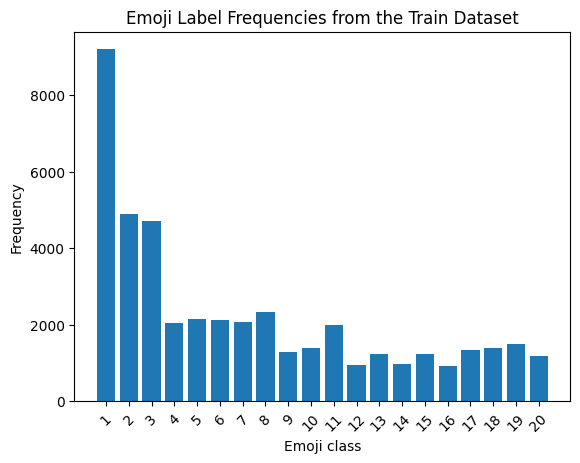

In [49]:
import matplotlib.pyplot as plt

def load_labels_as_dict(file_name: str):
    labels: dict = {}
    with open(file_name) as file:
        for label in file:
            label = int(label.strip()) + 1
            labels[label] = labels.get(label, 0) + 1
    return labels


def print_dict(dictionary):
    for key, value in sorted(dictionary.items()):
        print(key, value)


def plot_histogram(dictionary, keep_results: bool=False):
    bins = []
    frequencies = []
    for key, value in sorted(dictionary.items()):
        bins.append(str(key))
        frequencies.append(value)
    
    plt.bar(bins, frequencies)
    plt.xlabel('Emoji class')
    plt.ylabel('Frequency')
    plt.title('Emoji Label Frequencies from the Train Dataset')
    plt.xticks(rotation = 45)
    plt.savefig("emoji_frequencies.png")
    
    if keep_results:
        return bins, frequencies

labels = load_labels_as_dict("../data/train_labels.txt")
bins, frequencies = plot_histogram(labels, keep_results=True)

In [56]:
def augment(target: str, frequencies: [float]):
    fnt = "../data/" + target + "_text.txt"
    ft = open(fnt, 'r', encoding='utf-8')
    fnl = "../data/" + target + "_labels.txt"
    fl = open(fnl, 'r', encoding='utf-8')
    
    rfnt = "../data/aug_data/" + target + "_text_aug.txt"
    rft = open(rfnt, 'w', encoding='utf-8')
    rfnl = "../data/aug_data/" + target + "_labels_aug.txt"
    rfl = open(rfnl, 'w', encoding='utf-8')
    
    max_freq = max(frequencies)
    
    i = 0
    for tweet, label in zip(ft, fl):
        # Keep original tweet
        rft.write(tweet)
        rfl.write(label)
        
        # Augment enough to match highest pre-aug class
        this_freq = frequencies[int(label)]
        
        aug_tweets = get_augments(tweet, int(max_freq/this_freq))["tweet"]
        for aug_tweet in aug_tweets:
            if aug_tweet[-1] != '\n':
                aug_tweet += '\n'
            rft.write(aug_tweet)
            rfl.write(label)
        
        i+=1
        if i == 5:
            break

In [57]:
augment("test", frequencies)